# Subset surface climate data for eastern Australia

In [2]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [3]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '02:00:00'
cores = 48
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35569 instead
  warnings.warn(


In [6]:
cluster.scale(jobs=1)
client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.46.72:35569/status,
Dashboard: http://10.6.46.72:35569/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.46.72:41445,Workers: 0
Dashboard: http://10.6.46.72:35569/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import xarray as xr

In [8]:
import functions as fn

rez_boundary = fn.get_REZ_boundary()

# ERA5

In [9]:
years = range(1959, 2021)

In [10]:
root_path = '/g/data/rt52/era5/single-levels/reanalysis/'

# Solar radiation

Ideally we would have `ssrd` [Joules m^-2]. However, NCI does not store this variable.

Instead, (I think) we can use the Mean surface downward short-wave radiation flux `msdwswrf` [Watts m^-2]. This is the same as `ssrd` but expressed as a temporal average. In this case the average radiation per second over the hour.

Links:

- https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table4
- https://apps.ecmwf.int/codes/grib/param-db?id=169
- https://apps.ecmwf.int/codes/grib/param-db?id=235035
- https://www.ecmwf.int/sites/default/files/elibrary/2015/18490-radiation-quantities-ecmwf-model-and-mars.pdf

In [11]:
mssrd = fn.open_era_data(
    root_path=root_path,
    variable='msdwswrf',
    years=years,
    subset_region=rez_boundary,
    rename_lon_lat=['lon', 'lat']
)

Check size of dataset (in GB)

In [12]:
mssrd.nbytes / (1024 ** 3)

25.411483719944954

Plot mean field

In [13]:
mean_mssrd = mssrd['msdwswrf'].mean('time').compute()

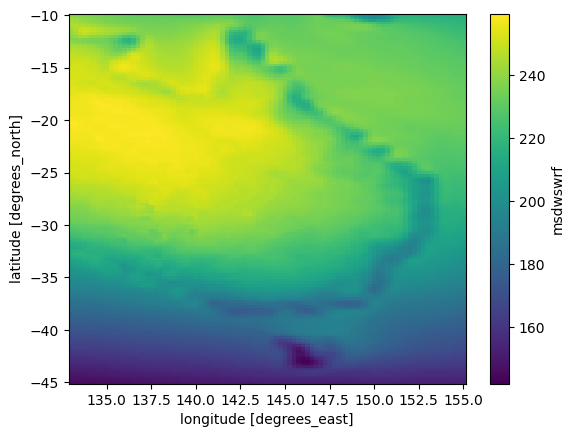

In [14]:
mean_mssrd.plot()

Re-chunk to ~100Mb chunks.

In [15]:
mssrd = mssrd.chunk({
    'time': 24*90,
    'lon': -1,
    'lat': -1
})

In [16]:
mssrd

<xarray.Dataset>
Dimensions:   (lon: 89, lat: 141, time: 543490)
Coordinates:
  * lon       (lon) float32 133.0 133.2 133.5 133.8 ... 154.2 154.5 154.8 155.0
  * lat       (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * time      (time) datetime64[ns] 1959-01-01T07:00:00 ... 2020-12-31T23:00:00
Data variables:
    msdwswrf  (time, lat, lon) float32 dask.array<chunksize=(2160, 141, 89), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-15 02:22:36 UTC+1000 by era5_replication_tools-1.11...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis mean_surface_downward_short_w...

Save to zarr

In [17]:
mssrd_encoding = {
    'msdwswrf': {
        'dtype': 'float32'
    }
}

In [18]:
mssrd.to_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_reanalysis_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    mode='w',
    consolidated=True,
    encoding=mssrd_encoding
)